In [3]:
pip install transformers datasets torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/archive.zip"
extract_to = "face_expression_dataset"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Extraction complete.


In [2]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


In [4]:
# Load the model and feature extractor
model_name = "trpakov/vit-face-expression"
model = AutoModelForImageClassification.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


class LimitedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, limit_per_class=700):
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for label_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            all_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            selected_images = all_images[:limit_per_class]
            for img_name in selected_images:
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Path to your dataset
test_dir = '/content/test_dataset'  # Replace this
test_dataset = LimitedImageDataset(test_dir, transform=transform, limit_per_class=700)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


# Accuracy
acc = accuracy_score(true_labels, predictions)
print(f"\nAccuracy: {acc * 100:.2f}%")

100%|██████████| 135/135 [00:55<00:00,  2.43it/s]


Accuracy: 60.38%


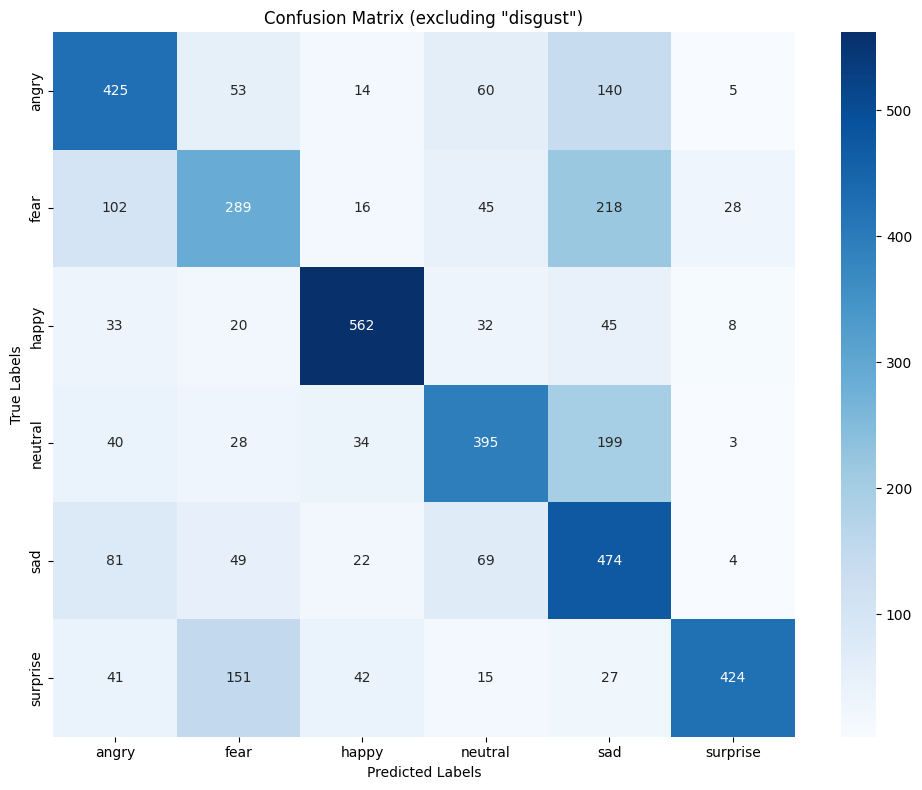

In [6]:

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Get class index for 'disgust' and remove its row & column
classes = test_dataset.classes
exclude_class = "disgust"

if exclude_class in classes:
    idx = classes.index(exclude_class)
    cm = np.delete(cm, idx, axis=0)  # remove row
    cm = np.delete(cm, idx, axis=1)  # remove column
    classes = [c for c in classes if c != exclude_class]

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding "disgust")')
plt.tight_layout()
plt.show()


Class: angry
  FNR: 0.3929
  FPR: 0.0964
  Treatment Equality (FNR/FPR): 4.0765

Class: fear
  FNR: 0.5871
  FPR: 0.0842
  Treatment Equality (FNR/FPR): 6.9743

Class: happy
  FNR: 0.1971
  FPR: 0.0363
  Treatment Equality (FNR/FPR): 5.4342

Class: neutral
  FNR: 0.4357
  FPR: 0.0620
  Treatment Equality (FNR/FPR): 7.0239

Class: sad
  FNR: 0.3229
  FPR: 0.1783
  Treatment Equality (FNR/FPR): 1.8103

Class: surprise
  FNR: 0.3943
  FPR: 0.0138
  Treatment Equality (FNR/FPR): 28.4753



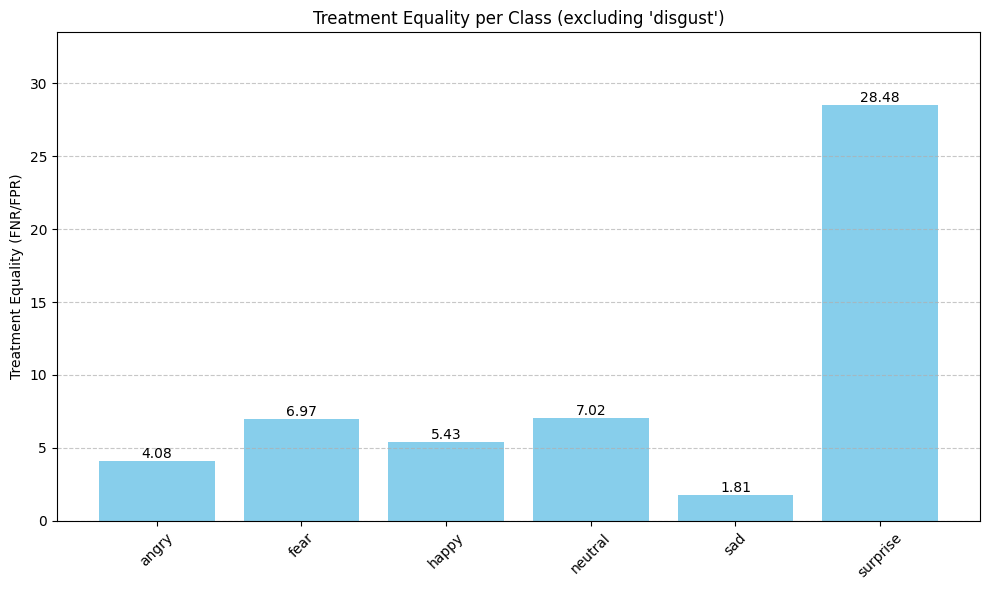

In [14]:
from sklearn.metrics import confusion_matrix

def calculate_treatment_equality(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names)))
    results = {}

    for idx, class_name in enumerate(class_names):
        # True Positives, False Negatives, False Positives, True Negatives
        TP = cm[idx, idx]
        FN = cm[idx, :].sum() - TP
        FP = cm[:, idx].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        TE = FNR / FPR if FPR > 0 else float('inf')

        results[class_name] = {
            "FNR": FNR,
            "FPR": FPR,
            "Treatment Equality (FNR/FPR)": TE
        }

    return results


results = calculate_treatment_equality(true_labels, predictions, class_names=test_dataset.classes)
print_treatment_equality_metrics(results)
plot_treatment_equality(results)


Demographic Parity (Proportion of each predicted class):
angry: 0.1793
fear: 0.1376
happy: 0.1608
neutral: 0.1436
sad: 0.2593
surprise: 0.11


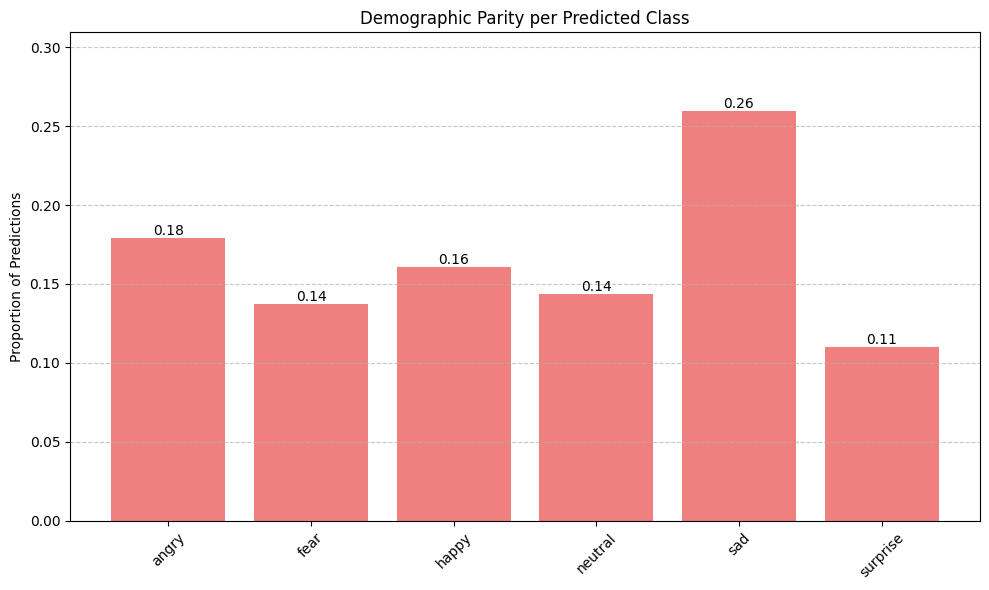

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

def calculate_demographic_parity(predictions, class_names):
    total_preds = len(predictions)
    pred_counts = Counter(predictions)

    parity = {}
    for i, class_name in enumerate(class_names):
        if class_name == "disgust":
            continue
        count = pred_counts[i]
        parity[class_name] = round(count / total_preds, 4)  # Proportion of predictions for each class

    return parity

def plot_demographic_parity(parity_dict):
    classes = list(parity_dict.keys())
    values = list(parity_dict.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, values, color='lightcoral')

    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.2f}",
                 ha='center', va='bottom', fontsize=10)

    plt.ylabel("Proportion of Predictions")
    plt.title("Demographic Parity per Predicted Class")
    plt.xticks(rotation=45)
    plt.ylim(0, max(values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call functions
demographic_parity = calculate_demographic_parity(predictions, class_names=test_dataset.classes)
print("Demographic Parity (Proportion of each predicted class):")
for cls, val in demographic_parity.items():
    print(f"{cls}: {val}")

plot_demographic_parity(demographic_parity)


In [25]:

def calculate_equal_opportunity(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names)))
    results = {}

    for idx, class_name in enumerate(class_names):
        if class_name == "disgust":
            continue
        # True Positives, False Negatives
        TP = cm[idx, idx]
        FN = cm[idx, :].sum() - TP

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate (Sensitivity / Recall)

        results[class_name] = TPR

    return results

equal_opp_results = calculate_equal_opportunity(true_labels, predictions, class_names=test_dataset.classes)

print("Equal Opportunity (TPR per class):")
for class_name, tpr in equal_opp_results.items():
    print(f"Class: {class_name}, TPR: {tpr:.4f}")



Equal Opportunity (TPR per class):
Class: angry, TPR: 0.6071
Class: fear, TPR: 0.4129
Class: happy, TPR: 0.8029
Class: neutral, TPR: 0.5643
Class: sad, TPR: 0.6771
Class: surprise, TPR: 0.6057


In [26]:
def calculate_generalized_entropy_index(true_labels, predicted_labels, class_names, alpha=2):

    true_labels = np.array(true_labels).flatten()
    predicted_labels = np.array(predicted_labels).flatten()

    results = {}
    class_accuracies = []

    for idx, class_name in enumerate(class_names):
        if class_name == "disgust":
            continue
        class_indices = np.where(true_labels == idx)[0]

        if len(class_indices) > 0:
            class_accuracy = np.mean(predicted_labels[class_indices] == true_labels[class_indices])
            class_accuracies.append(class_accuracy)

            results[class_name] = {
                "Accuracy": class_accuracy
            }

    class_accuracies = np.array(class_accuracies)
    mean_accuracy = np.mean(class_accuracies)

    if alpha == 1:
        gei = np.mean(class_accuracies / mean_accuracy * np.log(class_accuracies / mean_accuracy))
    elif alpha == 0:
        gei = np.mean(-np.log(class_accuracies / mean_accuracy))
    else:
        gei = 1 / (alpha * (alpha - 1)) * np.mean((class_accuracies / mean_accuracy) ** alpha - 1)

    # Add benefit ratios
    for class_name in results.keys():
        results[class_name]["Benefit Ratio"] = results[class_name]["Accuracy"] / mean_accuracy

    overall_results = {
        "Generalized Entropy Index": gei,
        "Mean Accuracy": mean_accuracy,
        "Min Accuracy": np.min(class_accuracies),
        "Max Accuracy": np.max(class_accuracies),
        "Accuracy Range": np.max(class_accuracies) - np.min(class_accuracies)
    }

    return results, overall_results


per_class_gei, overall_gei = calculate_generalized_entropy_index(true_labels, predictions, class_names=test_dataset.classes)

print("Per-Class GEI Metrics:")
for cls, metrics in per_class_gei.items():
    print(f"{cls}: Accuracy = {metrics['Accuracy']:.4f}, Benefit Ratio = {metrics['Benefit Ratio']:.4f}")

print("\nOverall GEI Metrics:")
for metric, value in overall_gei.items():
    print(f"{metric}: {value:.4f}")


Per-Class GEI Metrics:
angry: Accuracy = 0.6071, Benefit Ratio = 0.9926
fear: Accuracy = 0.4129, Benefit Ratio = 0.6750
happy: Accuracy = 0.8029, Benefit Ratio = 1.3126
neutral: Accuracy = 0.5643, Benefit Ratio = 0.9225
sad: Accuracy = 0.6771, Benefit Ratio = 1.1070
surprise: Accuracy = 0.6057, Benefit Ratio = 0.9903

Overall GEI Metrics:
Generalized Entropy Index: 0.0184
Mean Accuracy: 0.6117
Min Accuracy: 0.4129
Max Accuracy: 0.8029
Accuracy Range: 0.3900


In [35]:
import numpy as np


def calculate_disparate_impact(true_labels, predicted_labels, class_names, threshold=0.8):
    true_labels = np.array(true_labels).flatten()
    predicted_labels = np.array(predicted_labels).flatten()

    results = {}
    positive_rates = []

    for idx, class_name in enumerate(class_names):


        class_indices = np.where(true_labels == idx)[0]

        if len(class_indices) > 0:
            # Positive prediction rate: proportion of positive predictions
            class_positive_rate = np.sum(predicted_labels[class_indices] > 0) / len(class_indices)
            positive_rates.append(class_positive_rate)

            results[class_name] = {
                "Positive Prediction Rate": class_positive_rate
            }

    positive_rates = np.array(positive_rates)
    max_positive_rate = np.max(positive_rates)

    for idx, class_name in enumerate(class_names):
        if class_name in results:
            di_ratio = positive_rates[idx] / max_positive_rate
            results[class_name]["Disparate Impact Ratio"] = di_ratio
            results[class_name]["Below Threshold"] = "Yes" if di_ratio < threshold else "No"

    min_di_ratio = np.min(positive_rates) / max_positive_rate
    classes_below_threshold = [class_name for class_name in results if results[class_name]["Disparate Impact Ratio"] < threshold]

    overall_results = {
        "Min Disparate Impact Ratio": min_di_ratio,
        "Threshold": threshold,
        "Passes Threshold": "Yes" if min_di_ratio >= threshold else "No",
        "Classes Below Threshold": classes_below_threshold
    }

    return results, overall_results



per_class_di, overall_di = calculate_disparate_impact(true_labels, predictions, class_names=test_dataset.classes)

print("Per-Class Disparate Impact Metrics:")
for cls, metrics in per_class_di.items():
    print(f"{cls}: Positive Rate = {metrics['Positive Prediction Rate']:.4f}, "
          f"DI Ratio = {metrics['Disparate Impact Ratio']:.4f}, "
          f"Below Threshold = {metrics['Below Threshold']}")

print("\nOverall Disparate Impact Metrics:")
for metric, value in overall_di.items():
    print(f"{metric}: {value}")


Per-Class Disparate Impact Metrics:
angry: Positive Rate = 0.3929, DI Ratio = 0.4123, Below Threshold = Yes
disgust: Positive Rate = 0.5405, DI Ratio = 0.5673, Below Threshold = Yes
fear: Positive Rate = 0.8543, DI Ratio = 0.8966, Below Threshold = No
happy: Positive Rate = 0.9529, DI Ratio = 1.0000, Below Threshold = No
neutral: Positive Rate = 0.9429, DI Ratio = 0.9895, Below Threshold = No
sad: Positive Rate = 0.8843, DI Ratio = 0.9280, Below Threshold = No
surprise: Positive Rate = 0.9414, DI Ratio = 0.9880, Below Threshold = No

Overall Disparate Impact Metrics:
Min Disparate Impact Ratio: 0.4122938530734633
Threshold: 0.8
Passes Threshold: No
Classes Below Threshold: ['angry', 'disgust']
